##### Pass AWS Credentials and inspect the content of the bucket

In [1]:
import boto3
from botocore.exceptions import ClientError
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv(dotenv_path='/Users/Bei/Documents/Bei/Zrive/zrive-ds/zrive_ds/src/module_2/passwords.env')

# Get the AWS credentials from environment variables
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')


client = boto3.client('s3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key)

bucket_name = 'zrive-ds-data'

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)
bucket_objects = []
for obj in bucket.objects.all():
    print(obj.key)
    bucket_objects.append(obj.key)

ModuleNotFoundError: No module named 'boto3'

##### Download the sampled datasets

In [6]:
parquet_files = [i for i in bucket_objects if i.endswith(".parquet")]

client.download_file(bucket_name,parquet_files[0], "abandoned_carts.parquet")

destination_dir = 'groceries_datasets/'
os.mkdir(destination_dir)
for i in parquet_files:
    destination_file = f"{destination_dir}{i.split('/')[-1]}" 
    try:
        client.download_file(bucket_name,i, destination_file)
        print(f"Downloaded '{i}' from bucket '{bucket_name}' to '{destination_file}'.")
    
    except ClientError as e:
        print(f"Error downloading '{i}' from bucket '{bucket_name}': {e}")

NameError: name 'bucket_objects' is not defined

##### Inspect the Orders Table

In [ ]:
import pandas as pd

file_path = "groceries_datasets/orders.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
orders = pd.read_parquet(file_path)

# Display the first few rows
display(orders.head())
orders.info()
orders.dtypes
orders.count()
orders.describe()

: 

##### Inspect the Abandoned Carts Table

In [65]:
# Specify the path to your parquet file
file_path = "groceries_datasets/abandoned_carts.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
abandoned_carts = pd.read_parquet(file_path)

# Display the first few rows
display(abandoned_carts.head())
abandoned_carts.info()
abandoned_carts.dtypes
abandoned_carts.count()
abandoned_carts.describe()

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 3366719212762..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd...,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 3450282236326..."
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b...,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 3411360609088..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b8128084...,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 3443605520397..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153...,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[us]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 213.2+ KB


,id,created_at
count,5.457000e+03,5457
mean,2.161881e+13,2021-12-20 11:07:10.198460
min,1.285856e+13,2020-05-20 13:53:24
25%,2.133401e+13,2021-11-13 19:52:17
50%,2.167062e+13,2021-12-27 13:14:57
75%,2.192303e+13,2022-01-30 08:35:19
max,2.223385e+13,2022-03-13 14:12:10
std,4.028679e+11,NaN


##### Inspect the Inventory Table

In [66]:
# Specify the path to your parquet file
file_path = "groceries_datasets/inventory.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
inventory = pd.read_parquet(file_path)

# Display the first few rows
display(inventory.head())
inventory.info()
inventory.dtypes
inventory.count()
inventory.describe()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB


,variant_id,price,compare_at_price
count,1.733000e+03,1733.000000,1733.000000
mean,3.694880e+13,6.307351,7.028881
std,2.725674e+12,7.107218,7.660542
min,3.361529e+13,0.000000,0.000000
25%,3.427657e+13,2.490000,2.850000
50%,3.927260e+13,3.990000,4.490000
75%,3.948318e+13,7.490000,8.210000
max,4.016793e+13,59.990000,60.000000


##### Inspect the Regulars Table

In [67]:
# Specify the path to your parquet file
file_path = "groceries_datasets/regulars.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
regulars = pd.read_parquet(file_path)

# Display the first few rows
display(regulars.head())
regulars.info()
regulars.dtypes
regulars.count()
regulars.describe()

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11


<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB


,variant_id,created_at
count,1.810500e+04,18105
mean,3.511989e+13,2021-08-15 02:27:30.703728
min,3.361527e+13,2020-04-30 13:09:27
25%,3.382643e+13,2021-03-21 10:41:42
50%,3.422171e+13,2021-10-16 09:11:26
75%,3.448855e+13,2022-01-14 22:35:14
max,4.013362e+13,2022-03-14 07:49:24
std,2.171237e+12,NaN


##### Inspect the Users Table

In [68]:
# Specify the path to your parquet file
file_path = "groceries_datasets/users.parquet"


# Read the downloaded Parquet file into a pandas DataFrame
users = pd.read_parquet(file_path)

# Display the first few rows
display(users.head())
users.info()
users.dtypes
users.count()
users.describe()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB


,count_people,count_adults,count_children,count_babies,count_pets
count,325.000000,325.000000,325.000000,325.000000,325.000000
mean,2.787692,2.003077,0.707692,0.076923,0.636923
std,1.365753,0.869577,1.026246,0.289086,0.995603
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,1.000000,0.000000,1.000000
max,8.000000,7.000000,6.000000,2.000000,6.000000


##### Groceries Dataset Schema:
What we know:

- We have a dataset from an ecommerce site with the following schema:

![alt text](groceries_schema.png "Groceries Schema")


---

To investigate/validate:
- Users table:
    - Investigate:
        - What does the poeple/adults/children/pets/babies mean, and how it works? why do they have the same number of nulls?
        - Column customer_cohort_month, what does it mean?
        - column user_nuts1, what does it mean? is it a categorical variable?
        -  Is user_segment a ordinal variable?
    - Validate:
        - Are users only those who purchased an item or anyone who signed up?
            - Test: if there are users that do not have any purchase (first_ordered_at has NULLs) 
- Regulars table:
    - Validate:
        - Are these recurrent purchases?
            - Look at the purchases patterns for those users
- Orders table:
    - Validate:
        - It looks like ordered_items is a list with the variant_id of the products purchased
            - Check that the items in ordered_items exists as variant_id
- Abandoned Carts table:
    - Validate:
        - It looks like variant_id is a list with the variant_id of the products purchased
            - Check that the items in variant_id exists as variant_id

---

To do:
- In the case that ordered_items in the orders table and variant_id in abandoned_carts table are the product_ids, it would be easier to unnest those items so there is only one product per row.

- user_id is an object, it would be easier to manipulate if we converted it to a string.
    
- Investigate and validate hypotheses.
        
        
        
        
        
        
      

In [69]:
users.head()


user_categories = users[['count_people','count_adults','count_children','count_babies','count_pets']]

user_categories_clean = user_categories.dropna(how='all')

try:
    user_categories_clean['count_people'].sum() == user_categories_clean['count_adults'].sum() + user_categories_clean['count_children'].sum() + user_categories_clean['count_babies'].sum()
    print('The variable count_people is the sum of adults, children and babies')
except:
    print("Don't know what count_people means")



The variable count_people is the sum of adults, children and babies


Variable  count_adults  count_babies  count_children  count_people  count_pets
Value                                                                         
0.0                  3           302             195             2         193
1.0                 71            21              55            57          87
2.0                201             2              58            97          28
3.0                 32             0              12            68           8
4.0                 11             0               3            67           6
5.0                  5             0               1            24           2
6.0                  1             0               1             8           1
7.0                  1             0               0             1           0
8.0                  0             0               0             1           0


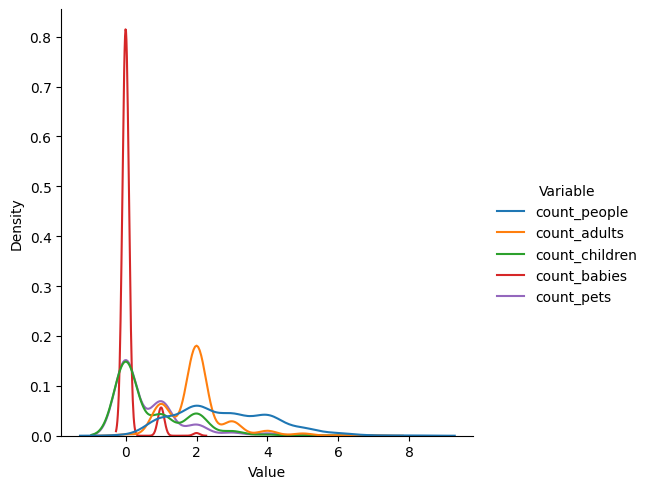

In [71]:
import seaborn as sns

user_categories_clean.groupby(list(user_categories_clean.columns)).size().reset_index(name="count")

df_melted = user_categories_clean.melt(var_name='Variable', value_name='Value')

sns.displot(df_melted,x='Value',hue='Variable',kind='kde')

print(df_melted.pivot_table(index='Value', columns='Variable', aggfunc='size', fill_value=0))